# Stock Price Prediction

In [50]:
ticker = 'TSLA'

## Imports

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests


## load data

In [52]:
stock_data = yf.Ticker(ticker)
df = stock_data.history(period="1y")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-11 00:00:00-04:00,264.269989,274.850006,260.609985,273.579987,174667900,0.0,0.0
2023-09-12 00:00:00-04:00,270.760010,278.390015,266.600006,267.480011,135999900,0.0,0.0
2023-09-13 00:00:00-04:00,270.070007,274.980011,268.100006,271.299988,111673700,0.0,0.0
2023-09-14 00:00:00-04:00,271.320007,276.709991,270.420013,276.040009,107709800,0.0,0.0
2023-09-15 00:00:00-04:00,277.549988,278.980011,271.000000,274.390015,133422800,0.0,0.0


## RSI Function

In [53]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

## ATR Function

In [54]:
def compute_atr(df, period=14):
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    return df['TR'].rolling(window=period).mean()

## Visualize Data

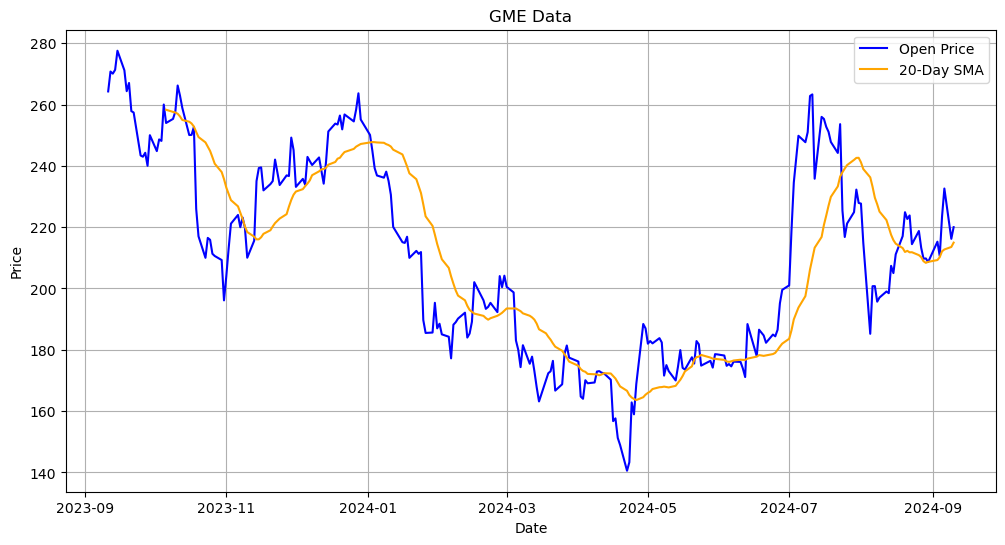

In [55]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

def plot_historical_data(ticker):

    # add indicators to graph
    df['SMA_20'] = df['Close'].rolling(window=20).mean() #SMA
    ## df['RSI'] = compute_rsi(df['Close']) #RSI
    ## df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean() #MACD
    ## df['Volatility'] = df['Close'].pct_change().rolling(window=20).std() #VOLATITLITY
    ## df['ATR'] = compute_atr(df) #ATR

    # Plot data
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Open'], label='Open Price', color='blue')
    plt.plot(df.index, df['SMA_20'], label='20-Day SMA', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Data')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_historical_data('GME')

## Sentiment Analysis

In [56]:
sid = SentimentIntensityAnalyzer()

api_key = 'your_api_key'
url = 'https://newsapi.org/v2/everything'
params = {
    'apiKey': api_key,
    'q': ticker,  
    'language': 'en',
    'pageSize': 50  # NUMBER OF ARTICLES
}

## Getting Sentiment Scores

In [57]:
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    articles = data.get('articles', [])
    sentiment_scores = [sid.polarity_scores(f"{article['title']} {article['description']}")['compound'] for article in articles]
    avg_sentiment = np.mean(sentiment_scores)
else:
    avg_sentiment = 0  # Default value in case of failure

## Features

Add Features as needed

In [58]:
df['SMA_20'] = df['Close'].rolling(window=20).mean() #SMA
## df['RSI'] = compute_rsi(df['Close']) #RSI
## df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean() #MACD
## df['Volatility'] = df['Close'].pct_change().rolling(window=20).std() #VOLATITLITY
## df['ATR'] = compute_atr(df) #ATR
df['Sentiment'] = avg_sentiment  ## SENTIMENT SCORE ##
df = df.dropna()

## Learning 

In [59]:
X = df.drop('Open', axis=1)
y = df['Open']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

pipeline = make_pipeline(StandardScaler())
X_train_scaled = pipeline.fit_transform(X_train)
X_val_scaled = pipeline.transform(X_val)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

## Training and Testing MSE and R^2

In [60]:
### TRAINING DATA ERROR/R^2 ###
y_train_pred = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

### VALIDATION DATA ERROR/R^2 ###
y_val_pred = model.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training Mean Squared Error: {train_mse}")
print(f"Training R-squared: {train_r2}")
print(f"Validation Mean Squared Error: {val_mse}")
print(f"Validation R-squared: {val_r2}")


Training Mean Squared Error: 3.9248714272918748
Training R-squared: 0.9958465180119487
Validation Mean Squared Error: 7.968526370246514
Validation R-squared: 0.9795546241086224


## Print Results

In [61]:
latest_data = df.iloc[-1:]
latest_features = latest_data.drop('Open', axis=1)
latest_features = pipeline.transform(latest_features)
predicted_open = model.predict(latest_features)

predicted_open = predicted_open[0]
print(predicted_open)

220.35449278329267


## Visualize Result

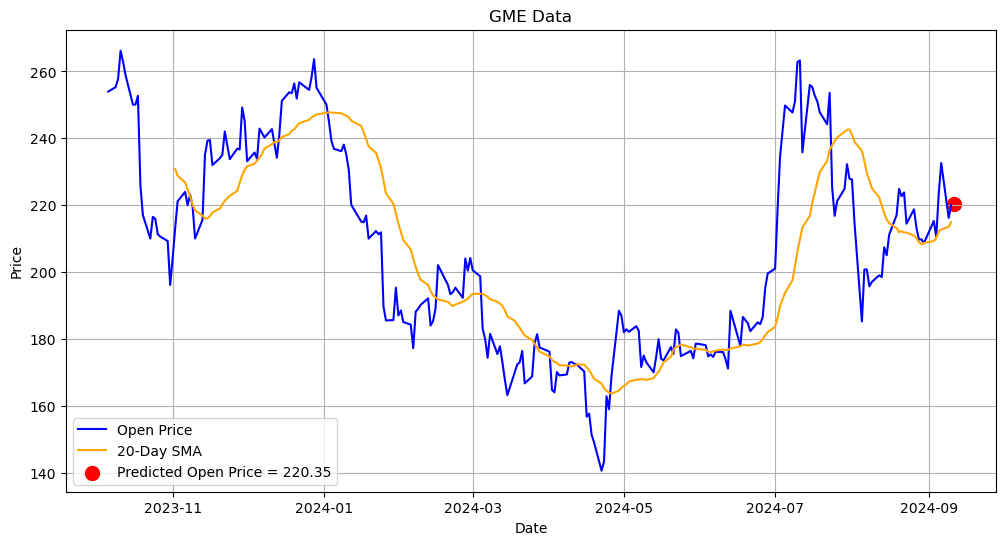

In [62]:
import matplotlib.pyplot as plt

def plot_predictions(ticker, predicted_open):
    # add indicators to graph
    df['SMA_20'] = df['Close'].rolling(window=20).mean() #SMA
    ## df['RSI'] = compute_rsi(df['Close']) #RSI
    ## df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean() #MACD
    ## df['Volatility'] = df['Close'].pct_change().rolling(window=20).std() #VOLATITLITY
    ## df['ATR'] = compute_atr(df) #ATR

    # Plot data
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Open'], label='Open Price', color='blue')
    plt.plot(df.index, df['SMA_20'], label='20-Day SMA', color='orange')

    # Highlight the predicted price
    plt.scatter(df.index[-1] + pd.DateOffset(days=1), predicted_open, color='red', s=100, label=f"Predicted Open Price = {np.round(predicted_open,2)}")

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Data')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_predictions('GME', predicted_open)
